# PreLab 04 : Numerical Integration

## Objectives

The main objectives of this lab are as follows.

- Learn the Zen of Python.
- Discover the incredible power of `scipy.integrate.quad`.

## Initialization

As always you should add initialization to the top of your notebook.

In [27]:
import numpy as np
import scipy
import scipy.integrate as integ
import matplotlib.pyplot as plt
print(scipy.__version__)


1.15.1


## Doing Things the "Right Way"

Why are we being so insistent that notebooks should be written in specific ways, enforcing all sorts of "rules" on what you do? There are a number of reasons that could be given, but, in the end, they reduce to this being the right way to create sustainable documents. In research it is often the case that we need to revisit calculations performed months or even years earlier. This could be due to a referee's comment on a paper suggesting some small change to try or it could be that we are working on a similar project and want to reuse code from the past. In this course it could be that you need to look back at the labs while working on the computational portion of the midterm or final exams! In such cases we typically will have forgotten the details of what we had been working on and instead only have the code sitting there. Notebooks make it much easier to leave this code in a documented, usable form. Even so, if we have implicitly made assumptions about the environment in which the code will be run, these assumptions will have been long since forgotten when we come back to the code, and thus we would need to spend a lot of time trying to figure out "what we were thinking" at the time. If instead we are explicit about all these details it will be much easier to figure out what the code is doing and how to use/reuse it.

In Python these ideas are even more strongly ingrained in the community. So much so that there is a "Zen of Python", a set of mantras to follow which will lead to better coding. Though you could search for this online, it is provided with Python itself.

  Run 
  ```python
  import this
  ```
  in the cell below.

In [28]:
import this

Now that your life has been changed we can proceed with the rest of the semeter ....

## Homework!

Read the homework and solve problem 1! Though it is not needed for this prelab and there is nothing you need to include here, you must read and solve this problem for the lab. You need a result from it to complete the lab. Note that this also means that you *will* get part of the homework correct since you will test the result in the lab.

## Romberg Integration?

Romberg integration is an example of using Richardson extrapolation in integration.
For many year `scipy.integrate` had a function called `romberg` to perform Romberg integration of a function.
Since I expect most of us are using scipy version 1.14 or older, I expect we still have this function.
You should look up its documentation.
If you try to use it you will get a warning telling you that the function is deprecated and that it will be removed in version 1.15.
Shockingly, **this function was actually removed** from scipy in version 1.15!
Obviously, we should never use it in new code.

On the other hand, `scipy.integrate.romb` still exists.
It does something similar.
Look up its documentation.
Briefly explain why it makes sense for this function to still exist but for the other version of the function to no longer exist.
What is the difference between these two functions?
Why is that important?

scipy.integrate.romberg was a function that could be evaluated at arbitary points. It was a lot more specific than the current function, which is scipy.integrate.romb. This function performs Romberg Integration on precomputed function values. This (probably) makes it more efficent for cases where function values are already computed.
We likely kept romb but removed romberg because romberg was redundent with integrate.quad while romb has a specific purpose. integration.romberg of a callable function or method while inegration.romb uses samples of a function, which is something that quad cannot do.

All that being said, we can still using Romberg integration through `scipy.integrate.romb`.
We will explore its use (and some other issues) by considering the integral
$$ \int_0^\phi \sqrt{2-\sin^2 x} \,\mathrm{d}x = \sqrt{2} E\!\left( \phi, \frac{1}{2} \right), $$
where $E(\phi,k)$ is the incomplete elliptic integral of the second kind.
It is available in scipy as `scipy.special.ellipeinc`.

Evaluate this integral for $\phi=58$ using `romb` where we have evaluated the function at 1025 points.
(The documentation for `romb` makes it clear why I chose a number of points of this form.)
Print the resulting value and its fractional error.
This error will be approximately $10^{-11}$.

In [29]:
def f(x):
    return np.sqrt(2 - (np.sin(x)**2))

phi = 58
N = 1025
x_vals = np.linspace(0, phi, N)
f_vals = f(x_vals)

romb_result = scipy.integrate.romb(f_vals, dx=x_vals[1] - x_vals[0])

exact_result = np.sqrt(2) * scipy.special.ellipeinc(phi, 1/2)

fractional_error_romb = abs(1 - (romb_result / exact_result))

# Print results
print(f"Romberg Integration Result: {romb_result}")
print(f"Exact Solution: {exact_result}")
print(f"Fractional Error: {fractional_error_romb}")


Romberg Integration Result: 70.55391225773273
Exact Solution: 70.55391225806629
Fractional Error: 4.727662705761304e-12


Let us compare this to `quad`.
Use `quad` to perform this integral.
Do not change the default tolerance settings.
**Only print** the value of the integral, the error estimate quad reports, the actual fractional error, and the total number of function evaluations required.
Notice how the reported error and the actual error can differ significantly.

In [30]:
quad_result, quad_error_estimate, info = scipy.integrate.quad(f, 0, phi, full_output=True)

fractional_error_quad = abs(1 - (quad_result / exact_result))

num_function_evals = info['neval']


print(f"Quad Integration Result: {quad_result}")
print(f"Exact Solution: {exact_result}")
print(f"Error for Quad from Function {quad_error_estimate}")
print(f"Fractional Error: {fractional_error_quad}")
print(f"Number of Evaluations {num_function_evals}")

Quad Integration Result: 70.55391225806716
Exact Solution: 70.55391225806629
Error for Quad from Function 9.372475279027874e-07
Fractional Error: 1.2212453270876722e-14
Number of Evaluations 1239


Though the above works and `quad` does a remarkable job with approximately the same number of function evaluations as we used with `romb`, this is not the most efficient way to calculate this integral.
To see why first produce a quick plot of the integrand over the full range of the integral.

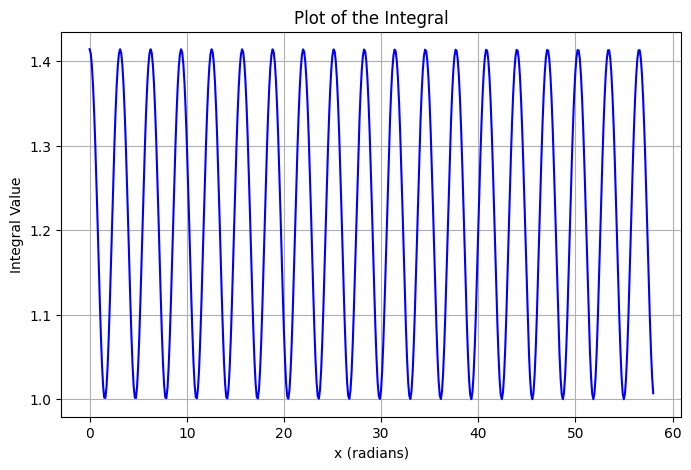

In [31]:
# Generate points
x = np.linspace(0, phi, 500)
y = f(x)

# Plot the function
plt.figure(figsize=(8, 5))
plt.plot(x, y, label=r"$\sqrt{2 - \sin^2 x}$", color='b')
plt.xlabel("x (radians)")
plt.ylabel("Integral Value")
plt.title("Plot of the Integral")
plt.grid(True)

You will notice that the function oscillates over a number of complete periods.
Determine the oscillation frequency of the integrand (this you can do analytically!), the number of complete oscillations of the integrand, and the remaining extra part of an incomplete period at the end of the integrals range.
Print these results.
(*Note:* Here it is useful to employ `//` for integer division (or the `int()` function) to get the integer part of a calculation and `%` for modular arithmetic.)

In [32]:
# Okay, so we know that the frequency of sin^2 is pi 
# This is because when sin^odd, then the period is 2pi, and when sin^even, the period is pi

#We can find the frequency 
oscillation_frequency = 1 / np.pi

#We can find all full osciallations and the rest
num_complete_oscillations = int(phi * oscillation_frequency)
remaining_fraction = phi / np.pi % 1

# Print results
print(f"Oscillation Frequency: {oscillation_frequency:.6f}")
print(f"Number of Complete Oscillations: {num_complete_oscillations}")
print(f"Remaining Part of Incomplete Period: {remaining_fraction:.6f} radians")

Oscillation Frequency: 0.318310
Number of Complete Oscillations: 18
Remaining Part of Incomplete Period: 0.461973 radians


It is more efficient to break up the complete integral into an integral over one period multiplied by the number of periods and an integral over the remaining part of a period.
Again use `quad` to separately evaluate these two integrals and combine them to get the complete result.
**Only print** the value of the total integral, its true fractional error, and the total number of function evaluations required in this case.
(We will ignore the error estimates produced by `quad`, a dangerous habit to acquire.)

In [33]:
(quad_result_full_osc, quad_error_estimate_full, info_full_osc) = scipy.integrate.quad(f, 0, np.pi, full_output=True)
num_function_evals_full = info_full_osc['neval']

(quad_result_remaining_osc, quad_error_estimate_remain, info_remin_osc) = scipy.integrate.quad(f, 0, remaining_fraction * np.pi, full_output=True)
num_function_evals_remain = info_remin_osc['neval']

combined = (quad_result_full_osc * num_complete_oscillations) + (quad_result_remaining_osc)

fractional_error_combined = np.abs(1 - (combined / exact_result))

print(f"The value of the integral when split up is {combined}")
print(f"The true fractional error is {fractional_error_combined}")
print(f"The number of function evaluations with splitting the integral up {num_function_evals_full + num_function_evals_remain}")

The value of the integral when split up is 70.55391225806628
The true fractional error is 2.220446049250313e-16
The number of function evaluations with splitting the integral up 84


Be amazed!
You should find a very accurate result from far fewer function evaluations!
Explain why far fewer function evaluations are required.

Fewer function evaluations are needed because the integral when it is split up because there is only two time that the function has to evaluate and they are over very small values. It is more efficent overall to break up the complete integral and add the remaining part of the integeral. 

Note that we could do even better. By symmetry, as seen in your plot above, we could instead integrate over a half period instead of a full period. Feel free to repeat the above now using a half period  You should find even fewer function evaluations are required!

**This is not required.** But will be included in the solutions.

In [34]:
# You are not required to use this cell.
# If you like, you can delete the contents to avoid it raising an error
# when you rerun the notebook.

## The Power of `quad`

As noted in class, `scipy.integrate.quad` is an extremely powerful integration routine.
Here we will study one set of features it provides without us even asking for it: the ability to handle divergences in the integrand at the end points of the integration range and integration over (semi-)infinite intervals.

### Divergent Integrand

Consider the integral
$$ \int_0^1 \frac{\mathrm{d}x}{\sqrt{x}}. $$
Notice that the integrand diverges for $x \to 0$.
You can perform this integral analytically. Do so! We will use the result below. 

Evaluate this integral with `quad`.
Print the value of the integral and the fractional error in the result (since you know the true value of the integral ...).
You should find it handles the integral with no problem and produces a very accurate result!

In [35]:
def sqrf(x):
    return 1 / np.sqrt(x)

quad, quad_error, info = scipy.integrate.quad(sqrf, 0, 1, full_output=True)

true_sqr = 2

fractional_error_sqr = np.abs(1 - (quad / true_sqr))

print(f"Integration Result: {quad}")
print(f"Exact Solution: {true_sqr}")
print(f"Error for Quad from Function {quad_error}")
print(f"Fractional Error: {fractional_error_sqr}")

Integration Result: 1.9999999999999984
Exact Solution: 2
Error for Quad from Function 5.773159728050814e-15
Fractional Error: 7.771561172376096e-16


### Semi-infinite Integral Range

Consider the integral
$$ \int_1^\infty \frac{\mathrm{d}x}{x^2} . $$
Once again we can perform this integral analytically.
Clearly this integral **cannot be performed** using a method like Romberg integration, Newton-Cotes formulas, *etc*., since we cannot evaluate them over an infinite range.
Similar to the previous case, if we needed to perform these problematic integrals using those techniques we would need to transform the integral in some way.
For this case it is relatively easy to do. If we let $y\equiv 1/x$ then we can show
$$ \int_1^\infty \frac{\mathrm{d}x}{x^2} = \int_0^1 \mathrm{d}y, $$
a very simple integral to evaluate!

This was a simple case, other integrands may be much more tedious to transform.
Once again `quad` can handle the semi-infinite range for us.
Use `quad` to perform the integral in its original, semi-infinite form.
Print the value of the integral and the fractional error in this value.
You should find that `quad` does exceptionally well, almost as if it were using the transformation we just discussed, ....
(*Note:* We can specify infinity in a few ways.
I will typically use `np.inf` though there also exists `np.infty` which is a little more explicit.)

In [36]:
def f2(x):
    return 1 / x**2

quad_f2, quad_error_f2, info_f2 = scipy.integrate.quad(f2, 1, np.inf, full_output=True)

true_f2 = 1

fractional_error_f2 = np.abs(1 - (quad_f2 / true_f2))

print(f"Integration Result: {quad_f2}")
print(f"Exact Solution: {true_f2}")
print(f"Error for Quad from Function {quad_error_f2}")
print(f"Fractional Error: {fractional_error_f2}")

Integration Result: 1.0
Exact Solution: 1
Error for Quad from Function 1.1102230246251565e-14
Fractional Error: 0.0


### Infinite Integral Range

Finally, `quad` can also handle a completely infinite range.
Consider the normalization integral for the Gaussian distribution that we have seen in previous labs,
$$ \frac{1}{\sqrt{2\pi}\sigma} \int_{-\infty}^\infty \exp\left[ -\frac{(x-\mu)^2}{2\sigma^2} \right] \mathrm{d}x = 1. $$
Again we could transform this to integrals over finite ranges.
In this case we could use various techniques, first shift the integral to remove the mean, $\mu$, from the integrand.
Then use symmetry to turn it into an integral over the semi-infinite range $(0,\infty)$.
Next split this integral into two pieces, an integral from $0$ to $1$ and an integral from $1$ to $\infty$.
Finally, this second integral can be handled by the transformation discussed in the semi-infinite case above.

Or, just let `quad` do it all for us!

Calculate this integral over the infinite interval using `quad`.
Print its value and fractional error.
Note that this result holds for arbitrary mean, $\mu$, and variance, $\sigma$; for your own purposes you should try a few cases.
Once again you should find (at least in the simplest case of $\mu=0$ and $\sigma=0$) it works extremely well!
(For other choices of $\mu$ and $\sigma$ the error may be larger.
You can think about why this makes sense.)

In [37]:
mu = 0
sig = 1

def gaus(x):
    return (np.exp(- ((x-mu)**2 / (2 * sig**2))))


true_gaus = (np.sqrt(2 * np.pi * sig)) 

quad_gaus, quad_error_gaus, info_gaus = scipy.integrate.quad(gaus, -np.inf, np.inf, full_output=True)


fractional_error_gaus = np.abs(1 - (quad_gaus / true_gaus))

print(f"Integration Result: {quad_gaus}")
print(f"Error for Quad from Function {quad_error_gaus}")
print(f"Fractional Error: {fractional_error_gaus}")

Integration Result: 2.5066282746309994
Error for Quad from Function 2.5512942220044495e-08
Fractional Error: 3.3306690738754696e-16


## Turning in the PreLab

All prelabs will be handled as was done for PreLab01. See that file for details. It will be assumed from now on that you have read and understood the procedure and what it means when you submit a prelab.